## Pygrader Core Modules

### imports

In [1]:
import os
import time
from pynput.keyboard import Key, Controller
import threading
import platform
import importlib

### to_funct()
to_funct() - Converts students program to a callable function. 
* Adds a function name - for calling, and return objects for validation of expected results
* This modified program is written as a new temporary program for execution. 

In [2]:
# convert tab-lengthed-spaces to tabs. 
import re

def entab(temp, tab_width=4, all=0):

        #if all is true, every time tab_width number of spaces are found next
        #to each other, they are converted to a tab.  If false, only those at
        #the beginning of the line are converted.  Default is false.

        if all:
                temp = re.sub(r" {" + str(tab_width) + r"}", r"\t", temp)
        else:
                patt = re.compile(r"^ {" + str(tab_width) + r"}", re.M)
                temp, count = patt.subn(r"\t", temp)
                i = 1
                while count > 0:
                        #this only loops a few times, at most six or seven times on
                        #heavily indented code
                        subpatt = re.compile(r"^\t{" + str(i) + r"} {" + str(tab_width) + r"}", re.M)
                        temp, count = subpatt.subn("\t"*(i+1), temp)
                        i += 1
        return temp


In [3]:
# going to try convert tab-lengthed spaces into tabs
#fpath = get_test_path(dir="prog_test_dir")
#file_name=os.path.join(fpath, "now_tabs.py")

def converts_space_tab(filename):
    new_filename = "now_tabs.py"
    with open(filename, "r") as in_file:
        buf = in_file.readlines()

    with open(new_filename, "w") as out_file:
        for line in buf:
            line = entab(line)
            out_file.write(line)

    return new_filename
          
          
                  
                  

In [4]:
def to_funct(fpath, file_name, return_results, cr_func_w_main=False):        
    '''
    function - reads into memory, the program undertests
        modifies the program by adding function definition and return statements, and writes
        to disk a new program (named _prg_undr_test.py) that can be imported
        and called by _prog_driver.py
        
        There are several different programs that this function parses: 
        | No Main Function & No Return Statement | 
        | Main Function    & No Return Statement | 
        | Main Function    & Return Statement | 
        
        In any case - to_funct() - needs to produce a new program with both a Main function and Return statement
            in order to programmatically execute the program. 
            
        Future consideration: 
            
            [code is too complex; should introduce regex to parsing logic, and reduce complexity, 
            and a number of unit tests]
            
            [ feb 2020 - added a unit test cell block, unit test folder, and beginning to
                add different programs that will exercise different paths of this function.]
        
        Maintained by kalen.howell@gmail.com 
    '''
    
    #print("working with file: " + file_name)
    
    file_name=converts_space_tab(os.path.join(fpath, file_name))
    #import ipdb; ipdb.set_trace() # debugging starts here
    if return_results != '':
        cr_return=True
    else:
        cr_return=False
        
    # ensure file is using TABS and not tab-lengthed-spaces
    
    with open(file_name, "r") as in_file:
        buf = in_file.readlines()
    cnt = 0
    if cr_func_w_main == False and cr_return==True:
        with open("_prg_undr_test" + ".py", "w") as out_file:
            for line in buf:
                if cnt == 0:
                    line = "def do_work():\n\t" + line
                else:
                    line = "\t" + line
                cnt =+1
                out_file.write(line)
            out_file.write("\n\treturn " + return_results)
    elif cr_func_w_main == True:
        in_funct = False
        ret_writen = False
        with open("_prg_undr_test" + ".py", "w") as out_file:
            for line in buf:
                # if we encounter a new function, backup 1 line
                # tab - enter return statement
                if cr_return ==True and "def " in line and in_funct == True:
                    # for some reason \t is adding 2 tabs. 
                    # using 4 spaces below instead: line = "    return"
                    line = "\treturn " + return_results + "\n" + line
                    in_funct = False
                    ret_writen = True
                if "def main()" in line:
                    line = "def do_work():\n"
                    in_funct = True
                if "main()" in line:
                    line = ''
                out_file.write(line)
            if ret_writen == False:
                out_file.write("\nreturn " + return_results)
    else:
        with open("_prg_undr_test" + ".py", "w") as out_file:
            for line in buf:
                out_file.write(line)


In [5]:
def cleanup():
    #CLEAN_UP_AFTER_RUN
    os.remove('_prg_undr_test.py') # removing program after loading into memory
    os.remove('now_tabs.py')

### Program Driver Cell Block
This code block - programmatically launches the temporary program (writen from above code), and conducts data-entry using provided input data. The student code processes that data according to the assignment requirements, and then returns the **actual results** to the calling function for verification (against **expected results**). 

In [6]:
# This Cell block represents: - a multithreaded application used to: 
# 1. launch the program under tests
# 2. drive data entry of the program under tests
# 3. compares expted results against actual results of the program under tests
# maintained by kalen.howell@gmail.com

def enter(data):
    '''
    function does data entry into program under tests.
    '''
    keyboard = Controller()
    
    for d in data:
        keyboard.press(d)
        keyboard.release(d)
    keyboard.press(Key.enter)
    keyboard.release(Key.enter)
    time.sleep(1)

def launch_typer(input_data):
    '''
    function does data entry into program under tests.
    '''
    time.sleep(1)
    for d in input_data:
        enter(d)

def launch_prg(prog, expected_results):
    '''
    launches program under tester, receives return values, and validates against expected results.
    '''
    results = prog.do_work()
    try:
        assert results == expected_results, "\n **FAILURE** \texpecting: " + str(expected_results) + "\n\trecieved: " + str(results) +"\n"
    except Exception as e: print(e)
    
def test(prog, input_data, expected_results):
    '''
    multithreaded function - 
        thread 1 - launches program under test, the other thread
        thread 2 - launches a typer programmer, which does data entry into the program under test
    '''
    prog_ut = threading.Thread(target=launch_prg, args=(prog, expected_results,),daemon=True)
    typer = threading.Thread(target=launch_typer, args=(input_data,), daemon=True)
    print('\n')
    
    prog_ut.start()
    typer.start()
    prog_ut.join()

def get_test_path(dir='test_dir'):
    '''
    Checks the host operating systems, and sets the working test path accordingly. 
    Default path - is working "test_dir" - the place to drop student programs to be tested. 
    ''' 
       
    win_fpath = 'C:\\Users\\KXH\\project_work\\python_work\\pygrader\\pygrader\\' + dir
    linux_fpath = '/Users/kalenhowellsr/Projects/code/pygrader/' + dir + '/'
    
    if platform.system() == "Windows":
        test_path = win_fpath
    else:
        test_path = linux_fpath  
    return test_path
        

## Program (Unit) Test Code

In [7]:
# ADDING DIFFERENT PROGRAMS AND ASSOCIATED TESTS - IN CASE UPDATES ARE NEEDED
#   TO PYGRADER CODE. ENSURE I DON'T BREAK ANYTHING WHEN MAKING CHANGES

# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

#### CALCULATE NUMB. OF INGREDIENTS FOR COOKIES
to_funct(fpath=get_test_path(dir="prog_test_dir"),
            file_name='Cookies.py',
            return_results='sugarNeeded, butterNeeded, flourNeeded',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver

import _prg_undr_test as prog
importlib.reload(prog) # flushes cache of previous test run's intermediate results

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['24'] , expected_results= (0.75, 0.5, 1.375))
test(prog, input_data=['65'] , expected_results= (2.03125, 1.3541666666666665, 3.723958333333333))
# the following produces an error for failure validation
test(prog, input_data=['65'] , expected_results= (2.03125, 1.3542666666666665, 3.723958333333333))

#### CALCULATE WEIGHT IN NEWTONS
to_funct(fpath=get_test_path(dir="prog_test_dir"),
            file_name='Weight.py',
            return_results='weight',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)  # flushes cache of previous test run's intermediate results
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['6'] , expected_results= (58.800000000000004))
test(prog, input_data=['49'] , expected_results= (480.20000000000005))
test(prog, input_data=['50'] , expected_results= (490.00000000000006))
test(prog, input_data=['102'] , expected_results= (999.6))

#### CONVERT NUMERICAL SCORE INTO LETTER GRADE
to_funct(fpath=get_test_path(dir="prog_test_dir"),
            file_name='Ch3Exercise.py',
            return_results='None',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['90'] , expected_results= None)
test(prog, input_data=['81.6'] , expected_results= None)
test(prog, input_data=['70'] , expected_results= None)
test(prog, input_data=['62.8'] , expected_results= None)
test(prog, input_data=['55.5'] , expected_results= None)
test(prog, input_data=['102'] , expected_results= None)
test(prog, input_data=['-1'] , expected_results= None)


# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

#### DEBUG 3 - BUDGET
to_funct(fpath=get_test_path(dir="prog_test_dir"),
            file_name='Debug3.py',
            return_results='total',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['20.27', '5', '10.2', '4.19', '0'] , expected_results= 19.39)
test(prog, input_data=['18.27', '5.5', '10.2', '4.19', '0'] , expected_results= 19.89)
test(prog, input_data=['20', '5', '10.0', '4.19', '0'] , expected_results= 19.19)


# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

#### DEBUG 2 - CHANGE COUNTING
to_funct(fpath=get_test_path(dir="prog_test_dir"),
            file_name='Debug2.py',
            return_results='totalDollars',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['10', '1','1','3'] , expected_results= 1)
test(prog, input_data=['12', '3','2','5'] , expected_results= 1.72)
test(prog, input_data=['9', '1','1','3'] , expected_results= .99)


# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

#### DEBUG 1 - MEAL, COST, TAX AND TIP
to_funct(fpath=get_test_path(dir="prog_test_dir"),
            file_name='Debug1.py',
            return_results='total',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['20.27'] , expected_results= 25.3375)

#### CONVERT KILOMETERS TO MILES
to_funct(fpath=get_test_path(dir="prog_test_dir"),
            file_name='conv_kilom_miles.py',
            return_results='result',
            cr_func_w_main=True)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)

#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['87'] , expected_results= 54.0618)
test(prog, input_data=['52.2'] , expected_results= 32.43708)
test(prog, input_data=['80000.0'] , expected_results= 49711.99999999999)



Enter the number of cookies: 24
The amount of sugar needed is: 0.750 cups
The amount of butter needed is: 0.500 cups
The amount of flour needed is: 1.375 cups


Enter the number of cookies: 65
The amount of sugar needed is: 2.031 cups
The amount of butter needed is: 1.354 cups
The amount of flour needed is: 3.724 cups


Enter the number of cookies: 65
The amount of sugar needed is: 2.031 cups
The amount of butter needed is: 1.354 cups
The amount of flour needed is: 3.724 cups

 **FAILURE** 	expecting: (2.03125, 1.3542666666666665, 3.723958333333333)
	recieved: (2.03125, 1.3541666666666665, 3.723958333333333)



Enter the mass of an object: 6
The object is too light. The weight is 58.8 newtons


Enter the mass of an object: 49
The weight is 480.2 newtons


Enter the mass of an object: 50
The weight is 490.0 newtons


Enter the mass of an object: 102
The object is too heavy. The weight is 999.6 newtons


Enter numerical score: 90
A


Enter numerical score: 81.6
B


Enter numerical scor

## Pygrade Assignment Test

### Summation

In [ ]:
# Summation Test
to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='sum.py',
            return_results='sum',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
os.remove('_prg_undr_test.py') # removing program after loading into memory

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['15', '45.29876','20000000','-3'] , expected_results= 20000060.29876)

### Cookies Recipe

In [ ]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Cookies.py',
            return_results='sugarNeeded, butterNeeded, flourNeeded',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)  # flushes cache of previous test run's intermediate results
#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['24'] , expected_results= (0.75, 0.5, 1.375))
test(prog, input_data=['65'] , expected_results= (2.03125, 1.3541666666666665, 3.723958333333333))




### Mass / Weight Converter

In [ ]:
#### pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Weight.py',
            return_results='weight',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
#CLEAN_UP_AFTER_RUN
cleanup()
# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['6'] , expected_results= (58.800000000000004))
test(prog, input_data=['49'] , expected_results= (480.20000000000005))
test(prog, input_data=['50'] , expected_results= (490.00000000000006))
test(prog, input_data=['102'] , expected_results= (999.6))


### Score to Grades Converter 

In [ ]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='grade.py',
            return_results='None',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['90'] , expected_results= None)
test(prog, input_data=['81.6'] , expected_results= None)
test(prog, input_data=['70'] , expected_results= None)
test(prog, input_data=['62.8'] , expected_results= None)
test(prog, input_data=['55.5'] , expected_results= None)
test(prog, input_data=['102'] , expected_results= None)
test(prog, input_data=['-1'] , expected_results= None)


### Summation

In [ ]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

# Summation Test
to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='sum.py',
            return_results='sum',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
#CLEAN_UP_AFTER_RUN
cleanup()
# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['15', '45.29876','20000000','-3'] , expected_results= 20000060.29876)


### Calculate Compound Interest
Manually Validate Generated Report

In [ ]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Compound.py',
            return_results='None',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['1500'] , expected_results= None)



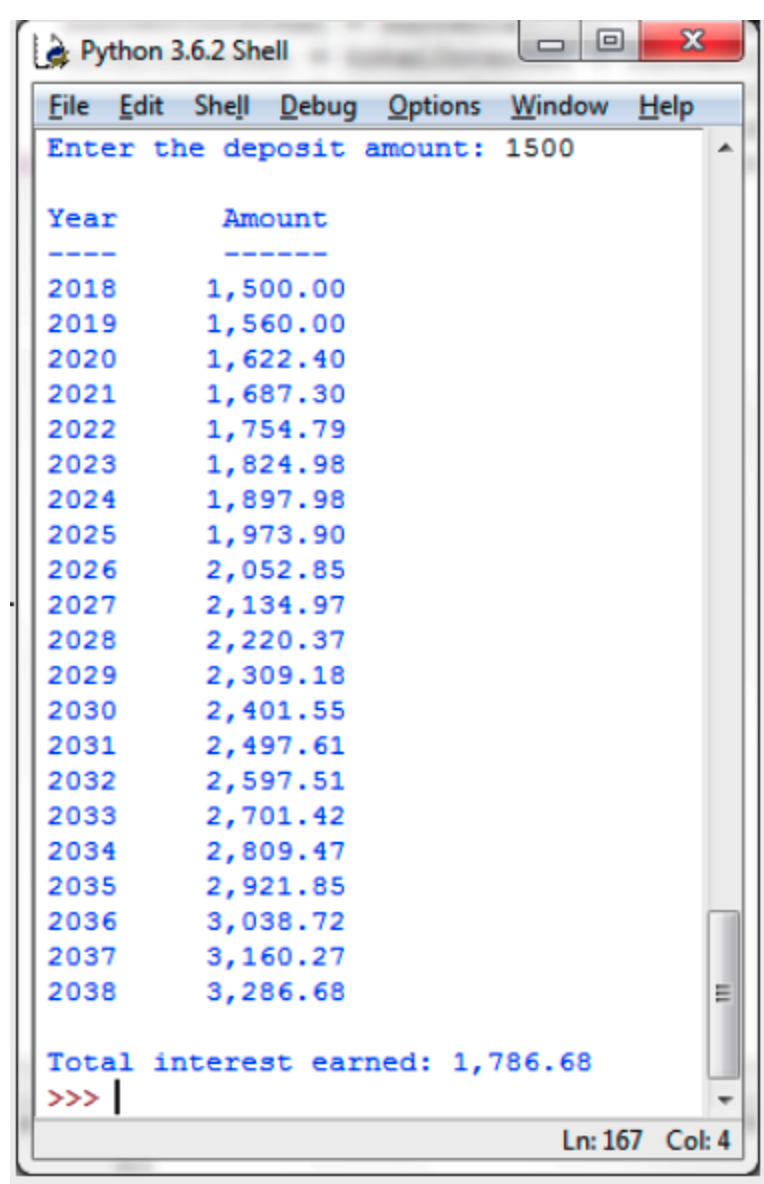

### Assignment: Debugging Exercises

#### Debugging Execersie #1

In [ ]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Debug1.py',
            return_results='total',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['20.27'] , expected_results= 25.3375)

#### Debugging Execersie #2

In [ ]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Debug2.py',
            return_results='totalDollars',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
os.remove('_prg_undr_test.py') # removing program after loading into memory

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['10', '1','1','3'] , expected_results= 1)
test(prog, input_data=['12', '3','2','5'] , expected_results= 1.72)
test(prog, input_data=['9', '1','1','3'] , expected_results= .99)


#### Debugging Execersie #3 

In [ ]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Debug3.py',
            return_results='total',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)
os.remove('_prg_undr_test.py') # removing program after loading into memory

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['20.27', '5', '10.2', '4.19', '0'] , expected_results= 19.39)
test(prog, input_data=['18.27', '5.5', '10.2', '4.19', '0'] , expected_results= 19.89)
test(prog, input_data=['20', '5', '10.0', '4.19', '0'] , expected_results= 19.19)

### Convert Kilometers to Miles

In [ ]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Ch5Ex1a.py',
            return_results='result',
            cr_func_w_main=True)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)

#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['87'] , expected_results= 54.0618)
test(prog, input_data=['52.2'] , expected_results= 32.43708)
test(prog, input_data=['80000.0'] , expected_results= 49711.99999999999)

### Read File, Validate Account Numbers.

In [31]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Ch7TextExercise.py',
            return_results='None',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)

#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['7825877'] , expected_results= None)
test(prog, input_data=['828293'] , expected_results= None)

# EXPECTED RESULTS: 
# 7825877 is valid
# 828293 is invalid




The numbers in the list are:  
 [97, 354, 136, 192, 188, 16, 217, 60, 326, 88, 467, 106, 315, 256, 480, 52, 384, 40, 447, 45, 146, 27, 304, 297, 385, 459, 177, 470, 295]
The numbers in the sorted list are:  
 [16, 27, 40, 45, 52, 60, 88, 97, 106, 136, 146, 177, 188, 192, 217, 256, 295, 297, 304, 315, 326, 354, 384, 385, 447, 459, 467, 470, 480]
Total :  6826
Average :  235.38
Median :  217


The numbers in the list are:  
 [375, 471, 275, 421, 135, 322, 207, 160, 20, 487, 423, 236, 449, 387, 382, 266, 192, 436, 121, 185, 182, 497, 445, 353, 234, 445, 137, 232, 8]
The numbers in the sorted list are:  
 [8, 20, 121, 135, 137, 160, 182, 185, 192, 207, 232, 234, 236, 266, 275, 322, 353, 375, 382, 387, 421, 423, 436, 445, 445, 449, 471, 487, 497]
Total :  8483
Average :  292.52
Median :  275


### Runs a general program, no input or validation

In [37]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Ch7Exercise_2.py',
            return_results='None',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)

#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=[''] , expected_results= None)

# EXPECTED RESULTS: 
# 




This program has generated the following random integers:
[128, 415, 350, 212, 471, 385, 420, 20, 299, 262, 316, 416, 47, 487, 477, 403, 311, 2, 346, 267, 431, 280, 26, 174, 387, 458, 477, 179, 449]
----------------------------------------------
Sorted from lowest to highest the numbers are:
[2, 20, 26, 47, 128, 174, 179, 212, 262, 267, 280, 299, 311, 316, 346, 350, 385, 387, 403, 415, 416, 420, 431, 449, 458, 471, 477, 477, 487]
----------------------------------------------
The total of the random numbers is: 8,895
----------------------------------------------
The average of the random numbers is: 306.72
----------------------------------------------
The median of the random numbers is: 346


### Ch7 Monthly Sales

In [18]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Ch7.py',
            return_results='None',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)

#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['13', '0', '12'] , expected_results= None)

# EXPECTED RESULTS
#Enter a month number (1-12): 13
#Invalid entry. Enter an integer month number (1-12): 0
#Invalid entry. Enter an integer month number (1-12): 12
#The December sales total is: 5,577.00
#The annual sales total is: 39,410.17




Enter a month number between 1 & 12:  13
Invalid entry. Enter a month number between 1 & 120
Invalid entry. Enter a month number between 1 & 1212
The December sales total is 5,577.00
The annual sales total is: 39,410.17


### Debugging Assignment 2

#### Debug1

In [70]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Debug1.py',
            return_results='maximum(num1, num2)',
            cr_func_w_main=True)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)

#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['130', '90'] , expected_results= 130.0)



Enter number 1: 130
Enter number 2: 90
The maximum is: 130.0
The maximum is: 130.0

 **FAILURE** 	expecting: 130.0
	recieved: None



#### Debug2

In [71]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Debug2.py',
            return_results='None',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)

#CLEAN_UP_AFTER_RUN
cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['test.txt'] , expected_results= None)

# TODO Update code to indicate a data file accompanies the program
# copy data file to parent directory test_dir.



Enter the name of the file: test.txt
one
two
three
four
five


#### Debug3

In [72]:
# pygrader_test.py - this is where the specific tests are configured. 

# tp.to_funct() - reads the program under test, and writes a new program, adding
#		necessary functions that are used to drive the program. 
# fpath - specify the path where the program under tests resides
# file_name - the name of the program to test
# return_results - the name of the primary function; returns results of prog execution  
# cr_func_w_main - True - indicates the program has main() function
#		   False - indicates the program has no function. so create one

to_funct(fpath=get_test_path(dir="test_dir"),
            file_name='Debug3.py',
            return_results='None',
            cr_func_w_main=False)

# after the new program is written, it is imported and driven by _prog_driver
import _prg_undr_test as prog
importlib.reload(prog)

#CLEAN_UP_AFTER_RUN
#cleanup()

# input_data - the data to be entered into the running program under tests. 
# expected_results - the expected results to be returned by the program under tests. 
test(prog, input_data=['10', '20','30','40','50','60','70'] , expected_results=None)

# EXPECTED RESULTS:
#Enter the sales for Sunday: 10
#Enter the sales for Monday: 20
#Enter the sales for Tuesday: 30
#Enter the sales for Wednesday: 40
#Enter the sales for Thursday: 50
#Enter the sales for Friday: 60
#Enter the sales for Saturday: 70
#Total sales for the week: $280.0

# TODO: should be passing TRUE to cr_func_main. Believe incorrectly parsing the program



Enter the amount of sales for Sunday
Enter the sales here: 10
Enter the amount of sales for Monday
Enter the sales here: 20
Enter the amount of sales for Tuesday
Enter the sales here: 30
Enter the amount of sales for Wednesday
Enter the sales here: 40
Enter the amount of sales for Thursday
Enter the sales here: 50
Enter the amount of sales for Friday
Enter the sales here: 60
Enter the amount of sales for Saturday
Enter the sales here: 70
The total sales for the week is : 280.00


##### 